<a href="https://colab.research.google.com/github/ahmer-talal/Neural-Networks/blob/main/BinaryClassification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from torch.utils.data import Dataset, DataLoader


## **Loading Dataset:** Built-In Breast Cancer Binary Classifier Dataset

In [48]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()

X = data.data        # features
y = data.target      # labels (0/1)

print(X.shape, y.shape)


(569, 30) (569,)


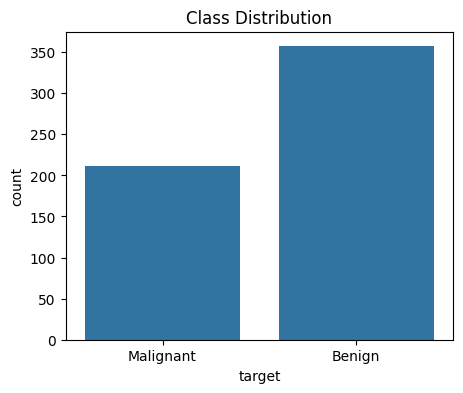

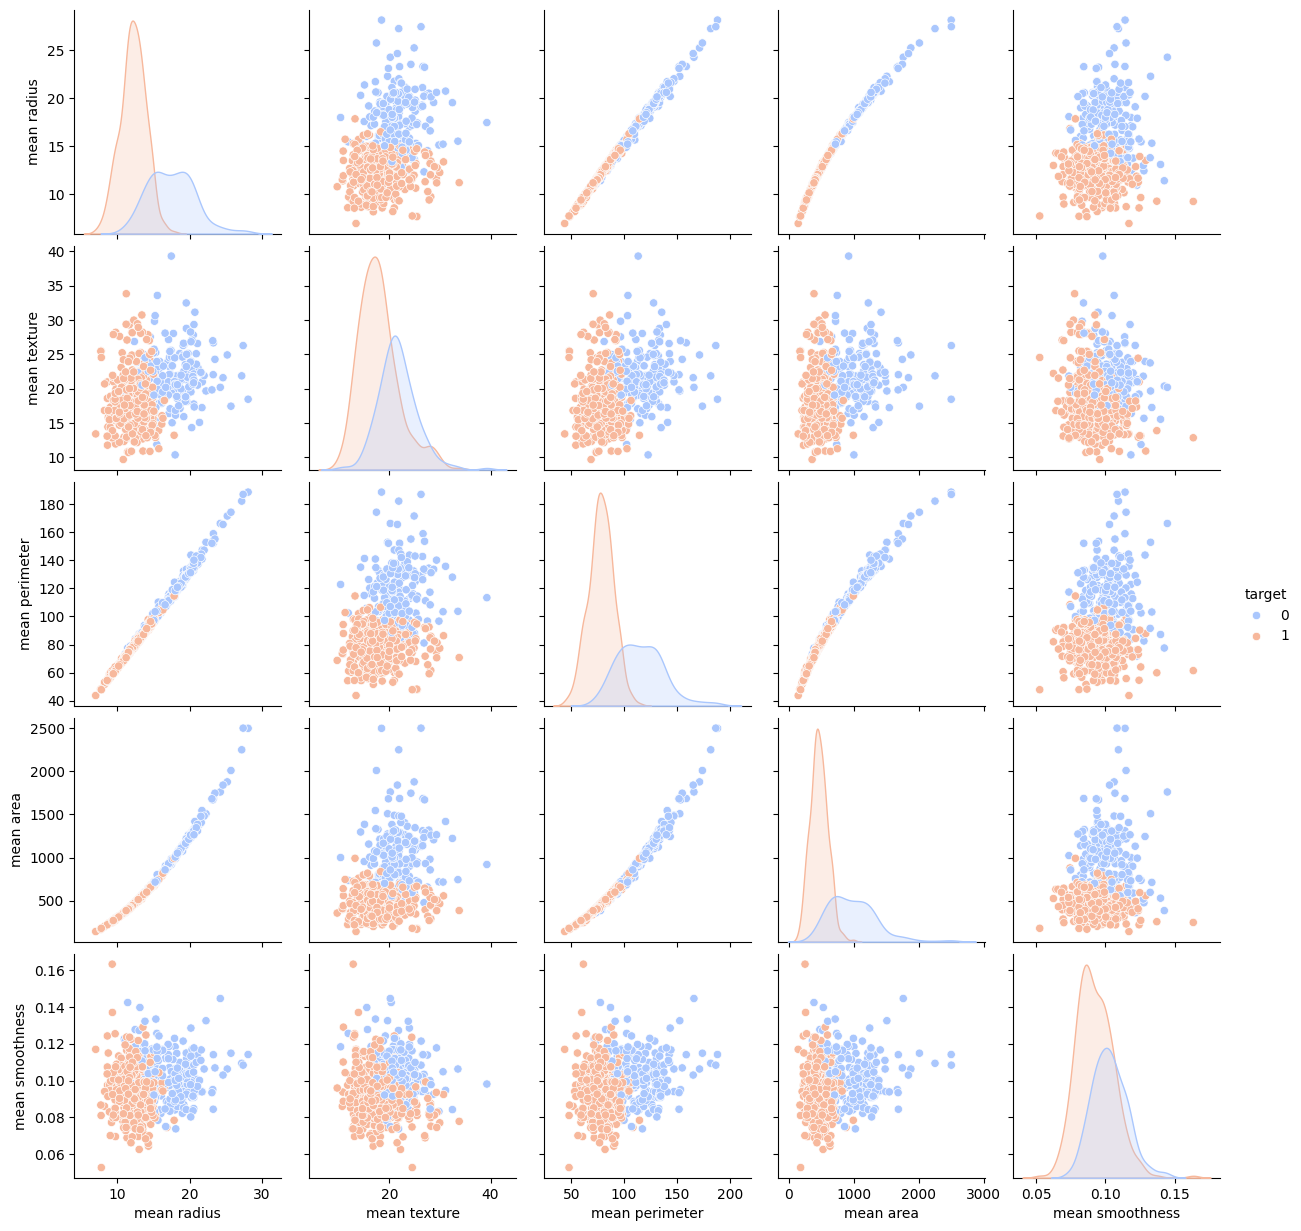

In [60]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame for easy visualization
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = Malignant, 1 = Benign

# 1 Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.xticks([0,1], ['Malignant', 'Benign'])
plt.title("Class Distribution")
plt.show()

# 2 Pairplot for first 5 features (for quick insight)
sns.pairplot(df.iloc[:, :5].join(df['target']), hue='target', palette="coolwarm")
plt.show()


## **Train / Validation / Test Splitting**

In [49]:
# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (398, 30) Val: (85, 30) Test: (86, 30)


## **Feature Scaling & Convert to Tensors**

In [50]:
from sklearn.preprocessing import StandardScaler
import torch

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_val   = torch.tensor(y_val, dtype=torch.float32).view(-1,1)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1,1)


## **DataLoader**

In [51]:
batch_size = 32

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)


## **Defining PyTorch Model**

In [52]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = CancerClassifier(input_dim=X_train.shape[1])


## **Loss & Optimizer**

In [53]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## **Training n Validation Loop**

In [54]:
epochs = 100
patience = 10          # early stopping patience
best_val_loss = float("inf")
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # --- Check Early Stopping & Save Best Model ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # --- Print Progress ---
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch [10/100] | Train Loss: 0.0866 | Val Loss: 0.0584
Epoch [20/100] | Train Loss: 0.0599 | Val Loss: 0.0445
Epoch [30/100] | Train Loss: 0.0402 | Val Loss: 0.0448
Early stopping triggered at epoch 34


## **Loading Saved Model**

In [55]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


CancerClassifier(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

## **Testing**

In [56]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        preds = (outputs >= 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(preds.numpy())
        all_labels.extend(yb.numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 95.35%


In [62]:
def predict_single(sample_features):
    """
    sample_features: list or numpy array of 30 features
    """
    model.eval()
    sample = np.array(sample_features).reshape(1, -1)
    sample_scaled = scaler.transform(sample)  # scale like training
    sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

    with torch.no_grad():
        output = model(sample_tensor)
        pred = (output >= 0.5).float().item()

    if pred == 1:
        print("Prediction: Benign (Class 1)")
    else:
        print("Prediction: Malignant (Class 0)")

# Example: Test first 6 samples from test set
for i in range(6):
    print(f"\nSample {i+1}:")
    predict_single(X_test[i].numpy())



Sample 1:
Prediction: Malignant (Class 0)

Sample 2:
Prediction: Malignant (Class 0)

Sample 3:
Prediction: Malignant (Class 0)

Sample 4:
Prediction: Malignant (Class 0)

Sample 5:
Prediction: Malignant (Class 0)

Sample 6:
Prediction: Malignant (Class 0)


In [63]:
# Example for interactive testing (type values in console)
custom_input = []

print("Enter 30 feature values for prediction:")
for feature in data.feature_names:
    val = float(input(f"{feature}: "))
    custom_input.append(val)

predict_single(custom_input)


Enter 30 feature values for prediction:
mean radius: 45
mean texture: 44
mean perimeter: 43
mean area: 41
mean smoothness: 40
mean compactness: 39
mean concavity: 32
mean concave points: 33
mean symmetry: 22
mean fractal dimension: 44
radius error: 44
texture error: 22
perimeter error: 22
area error: 22
smoothness error: 22
compactness error: 22
concavity error: 22
concave points error: 22
symmetry error: 11
fractal dimension error: 12
worst radius: 12
worst texture: 11
worst perimeter: 11
worst area: 11
worst smoothness: 11
worst compactness: 11
worst concavity: 12
worst concave points: 32
worst symmetry: 34
worst fractal dimension: 54
Prediction: Benign (Class 1)


## **Confusion Matrix & Classification Report**

In [57]:
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Confusion Matrix:
[[30  2]
 [ 2 52]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        32
         1.0       0.96      0.96      0.96        54

    accuracy                           0.95        86
   macro avg       0.95      0.95      0.95        86
weighted avg       0.95      0.95      0.95        86



## **Visualize Training vs Validation Loss**

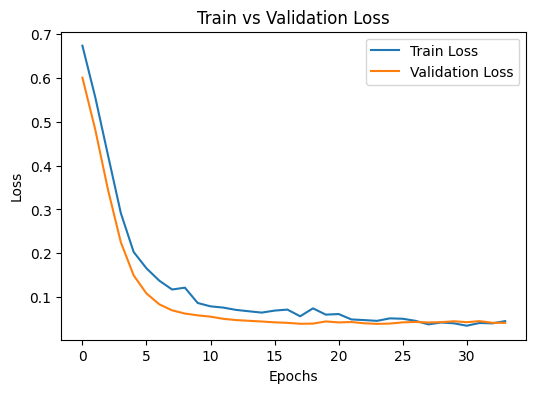

In [58]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()
